# Disaster Tweet Classifer

## Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

## I. Importing and Analysing Dataset

In [2]:
train_df = pd.read_csv("./dataset/train.csv")
test_df  = pd.read_csv("./dataset/test.csv")

In [3]:
print(f"train df columns name: {train_df.columns}")
print(f"test df columns name: {test_df.columns}")

train df columns name: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
test df columns name: Index(['id', 'keyword', 'location', 'text'], dtype='object')


### Check Actual & Fake Tweets

#### Fake Disaster Tweets

In [4]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

#### Actual Disaster Tweets

In [5]:
train_df[train_df["target"] != 0]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

## II. Preparing Data

### Utility Functions

In [6]:
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

### Counting the number of unique words

In [7]:
text_values = train_df["text"]

counter = counter_word(text_values)

### Defining Constants for Classification

In [8]:
vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each tweet.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

### Splitting Train-Test Data

In [9]:
training_sentences = train_df.text[0:training_size]
training_labels = train_df.target[0:training_size]

testing_sentences = train_df.text[training_size:]
testing_labels = train_df.target[training_size:]

### Tokenizing Input, Sequencing, and Padding

In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

In [11]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## III. Defining Classifier Model (LSTM Binary Classifier)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # for a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
num_epochs = 10
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 14s 2ms/sample - loss: 0.5394 - acc: 0.7261 - val_loss: 0.4785 - val_acc: 0.7814
Epoch 2/10
6090/6090 [==============================] - 13s 2ms/sample - loss: 0.2911 - acc: 0.8897 - val_loss: 0.4912 - val_acc: 0.7820
Epoch 3/10
6090/6090 [==============================] - 13s 2ms/sample - loss: 0.1388 - acc: 0.9516 - val_loss: 0.6387 - val_acc: 0.7492
Epoch 4/10
6090/6090 [==============================] - 13s 2ms/sample - loss: 0.0775 - acc: 0.9727 - val_loss: 0.6818 - val_acc: 0.7525
Epoch 5/10
6090/6090 [==============================] - 13s 2ms/sample - loss: 0.0502 - acc: 0.9829 - val_loss: 0.8067 - val_acc: 0.7347
Epoch 6/10
6090/6090 [==============================] - 13s 2ms/sample - loss: 0.0411 - acc: 0.9872 - val_loss: 0.7990 - val_acc: 0.7466
Epoch 7/10
6090/6090 [==============================] - 13s 2ms/sample - loss: 0.0288 - acc: 0.9910 - val_loss: 0.8783 - val_acc: 

## IV. Evaluating Tweet Classifier Model

In [14]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,acc,val_loss,val_acc
0,0.539435,0.726108,0.478480,0.781353
1,0.291134,0.889655,0.491247,0.782009
2,0.138840,0.951560,0.638690,0.749179
3,0.077470,0.972742,0.681808,0.752462
4,0.050177,0.982923,0.806658,0.734734


### Plotting Accuracy and Validation Data Accuracy

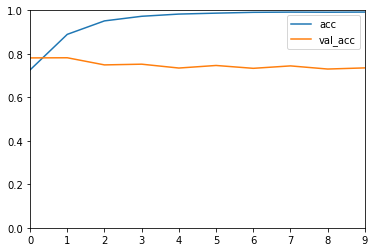

In [16]:
model_loss[['acc','val_acc']].plot(ylim=[0,1])